In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import random
import time
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc,
    roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
)

# Set float format to 4 decimal places
pd.options.display.float_format = '{:.4f}'.format

In [ ]:
# -----------------------------
# Data Loading & Preprocessing
# -----------------------------
df = pd.read_csv('/content/drive/MyDrive/Thesis_CKD/FSDM2025/Kidney_Disease_Dataset_cleaned.csv')
target_col = 'class'
X = df.drop(columns=[target_col])
y = df[target_col]
df.info()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      400 non-null    int64  
 1   blood_pressure           400 non-null    int64  
 2   specific_gravity         400 non-null    float64
 3   albumin                  400 non-null    int64  
 4   sugar                    400 non-null    int64  
 5   red_blood_cells          400 non-null    int64  
 6   pus_cell                 400 non-null    int64  
 7   pus_cell_clumps          400 non-null    int64  
 8   bacteria                 400 non-null    int64  
 9   blood_glucose_random     400 non-null    int64  
 10  blood_urea               400 non-null    float64
 11  serum_creatinine         400 non-null    float64
 12  sodium                   400 non-null    float64
 13  potassium                400 non-null    float64
 14  haemoglobin              4

In [ ]:
# ========== F1 Evaluation with 70/30 Split ==========
def evaluate_f1(model, params, X, y, test_size=0.3, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    model.set_params(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    return 1 - f1

In [ ]:
# ========== Optimizers ==========
def firefly_with_init(obj_func, init_positions, bounds, max_iter, alpha=0.5, beta0=1, gamma=1):
    fireflies = init_positions.copy()
    n_pop, dim = fireflies.shape
    intensities = np.array([obj_func(f) for f in fireflies])
    best_scores = []
    print(f"Model: {model_name} - FA")
    for t in range(max_iter):
        for i in range(n_pop):
            for j in range(n_pop):
                if intensities[j] < intensities[i]:
                    r = np.linalg.norm(fireflies[i] - fireflies[j])
                    beta = beta0 * np.exp(-gamma * r ** 2)
                    step = beta * (fireflies[j] - fireflies[i]) + alpha * (np.random.rand(dim) - 0.5)
                    fireflies[i] += step
                    fireflies[i] = np.clip(fireflies[i], [b[0] for b in bounds], [b[1] for b in bounds])
                    intensities[i] = obj_func(fireflies[i])
        best_scores.append(np.min(intensities))
        if (t + 1) % 5 == 0:
            print(f"Iteration {t + 1}/{max_iter}, Best Score: {np.min(intensities):.4f}")
    return fireflies[np.argmin(intensities)], np.min(intensities), best_scores

def gwo_with_init(obj_func, init_positions, bounds, max_iter):
    wolves = init_positions.copy()
    n_pop, dim = wolves.shape
    alpha_pos, beta_pos, delta_pos = None, None, None
    alpha_score, beta_score, delta_score = float('inf'), float('inf'), float('inf')
    best_scores = []
    print(f"Model: {model_name} - GWO")
    for t in range(max_iter):
        for i in range(n_pop):
            fitness = obj_func(wolves[i])
            if fitness < alpha_score:
                delta_score, delta_pos = beta_score, beta_pos
                beta_score, beta_pos = alpha_score, alpha_pos
                alpha_score, alpha_pos = fitness, wolves[i].copy()
            elif fitness < beta_score:
                delta_score, delta_pos = beta_score, beta_pos
                beta_score, beta_pos = fitness, wolves[i].copy()
            elif fitness < delta_score:
                delta_score, delta_pos = fitness, wolves[i].copy()
        a = 2 - t * (2 / max_iter)
        for i in range(n_pop):
            new_pos = []
            for d in range(dim):
                r1, r2 = np.random.rand(), np.random.rand()
                A, C = 2 * a * r1 - a, 2 * r2
                D_alpha = abs(C * alpha_pos[d] - wolves[i, d])
                X1 = alpha_pos[d] - A * D_alpha
                r1, r2 = np.random.rand(), np.random.rand()
                A, C = 2 * a * r1 - a, 2 * r2
                D_beta = abs(C * beta_pos[d] - wolves[i, d])
                X2 = beta_pos[d] - A * D_beta
                r1, r2 = np.random.rand(), np.random.rand()
                A, C = 2 * a * r1 - a, 2 * r2
                D_delta = abs(C * delta_pos[d] - wolves[i, d])
                X3 = delta_pos[d] - A * D_delta
                new_pos.append((X1 + X2 + X3) / 3)
            wolves[i] = np.clip(new_pos, [b[0] for b in bounds], [b[1] for b in bounds])
        best_scores.append(alpha_score)
        if (t + 1) % 5 == 0:
            print(f"Iteration {t + 1}/{max_iter}, Best Score: {alpha_score:.4f}")
    return alpha_pos, alpha_score, best_scores

def hybrid_fa_gwo_init(obj_func, init_positions, bounds, max_iter, alpha=0.5, beta0=1, gamma=1):
    wolves = init_positions.copy()
    n_agents, dim = wolves.shape
    alpha_wolf, beta_wolf, delta_wolf = None, None, None
    alpha_score, beta_score, delta_score = float('inf'), float('inf'), float('inf')
    best_scores = []
    print(f"Model: {model_name} - Hybrid FA-GWO")
    for t in range(max_iter):
        for i in range(n_agents):
            score = obj_func(wolves[i])
            if score < alpha_score:
                delta_score, delta_wolf = beta_score, beta_wolf
                beta_score, beta_wolf = alpha_score, alpha_wolf
                alpha_score, alpha_wolf = score, wolves[i].copy()
            elif score < beta_score:
                delta_score, delta_wolf = beta_score, beta_wolf
                beta_score, beta_wolf = score, wolves[i].copy()
            elif score < delta_score:
                delta_score, delta_wolf = score, wolves[i].copy()
        a = 2 - t * (2 / max_iter)
        for i in range(n_agents):
            gwo_position = []
            for d in range(dim):
                r1, r2 = np.random.rand(), np.random.rand()
                A, C = 2 * a * r1 - a, 2 * r2
                D_alpha = abs(C * alpha_wolf[d] - wolves[i, d])
                X1 = alpha_wolf[d] - A * D_alpha
                r1, r2 = np.random.rand(), np.random.rand()
                A, C = 2 * a * r1 - a, 2 * r2
                D_beta = abs(C * beta_wolf[d] - wolves[i, d])
                X2 = beta_wolf[d] - A * D_beta
                r1, r2 = np.random.rand(), np.random.rand()
                A, C = 2 * a * r1 - a, 2 * r2
                D_delta = abs(C * delta_wolf[d] - wolves[i, d])
                X3 = delta_wolf[d] - A * D_delta
                gwo_position.append((X1 + X2 + X3) / 3)
            r = np.linalg.norm(wolves[i] - gwo_position)
            beta = beta0 * math.exp(-gamma * r ** 2)
            step = beta * (np.array(gwo_position) - wolves[i]) + alpha * (np.random.rand(dim) - 0.5)
            wolves[i] = np.clip(wolves[i] + step, [b[0] for b in bounds], [b[1] for b in bounds])
        best_scores.append(alpha_score)
        if (t + 1) % 5 == 0:
            print(f"Iteration {t + 1}/{max_iter}, Best Score: {alpha_score:.4f}")
    return alpha_wolf, alpha_score, best_scores

In [ ]:
# ========== Models and Optimization Loop ==========
models = {
    'SVM': {'model': SVC(kernel='rbf', probability=True), 'bounds': [(0.1, 100), (0.0001, 1)]},
    'RF':  {'model': RandomForestClassifier(random_state=42), 'bounds': [(50, 200), (2, 15)]},
    'KNN': {'model': KNeighborsClassifier(), 'bounds': [(2, 20)]}
}

opt_results = []
roc_data = {}
convergence = {'FA': {}, 'GWO': {}, 'Hybrid': {}}
n_agents = 10
max_iter = 20

In [ ]:
for model_name, info in models.items():
    model_base, bounds = info['model'], info['bounds']
    dim = len(bounds)

    for opt_name, opt_func in zip(['FA', 'GWO', 'Hybrid'], [firefly_with_init, gwo_with_init, hybrid_fa_gwo_init]):
        def obj(params):
            if model_name == 'SVM':
                # Create a new SVC instance with probability=True for evaluation
                eval_model = SVC(kernel='rbf', probability=True)
                return evaluate_f1(eval_model, {'C': params[0], 'gamma': params[1]}, X_train_scaled, y_train)
            elif model_name == 'RF':
                # Create a new RandomForestClassifier instance for evaluation
                eval_model = RandomForestClassifier(random_state=42)
                return evaluate_f1(eval_model, {'n_estimators': int(params[0]), 'max_depth': int(params[1])}, X_train_scaled, y_train)
            else:
                 # Create a new KNeighborsClassifier instance for evaluation
                eval_model = KNeighborsClassifier()
                return evaluate_f1(eval_model, {'n_neighbors': int(params[0])}, X_train_scaled, y_train)

        init = np.random.rand(n_agents, dim)
        for i in range(dim):
            init[:, i] = init[:, i] * (bounds[i][1] - bounds[i][0]) + bounds[i][0]

        best_pos, _, curve = opt_func(obj, init.copy(), bounds, max_iter)
        convergence[opt_name][model_name] = curve

        if model_name == 'SVM':
             model = SVC(kernel='rbf', probability=True)
        elif model_name == 'RF':
             model = RandomForestClassifier(random_state=42)
        else:
             model = KNeighborsClassifier()

        if model_name == 'SVM':
            best_params = {'C': best_pos[0], 'gamma': best_pos[1]}
        elif model_name == 'RF':
            best_params = {'n_estimators': int(best_pos[0]), 'max_depth': int(best_pos[1])}
        else:
            best_params = {'n_neighbors': int(best_pos[0])}

        model.set_params(**best_params)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_data[(model_name, opt_name)] = (fpr, tpr)

        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_data[model_name] = (fpr, tpr)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc_val = roc_auc_score(y_test, y_prob)

        print(f"===================")
        print(f"Model: {model_name} | Optimizer: {opt_name}")
        print(f"Best Params: {best_params}")
        print(f"Accuracy: {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall: {rec:.4f}")
        print(f"F1-score: {f1:.4f}")
        print(f"AUC: {auc_val:.4f}")
        print(f"===================\n")

        opt_results.append({
            'Model': model_name,
            'Optimizer': opt_name,
            'Best Params': best_params,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1-score': f1,
            'AUC': auc_val
        })

Model: SVM - FA
Iteration 5/20, Best Score: 0.0256
Iteration 10/20, Best Score: 0.0256
Iteration 15/20, Best Score: 0.0256
Iteration 20/20, Best Score: 0.0256
Model: SVM | Optimizer: FA
Best Params: {'C': np.float64(81.40948023712568), 'gamma': np.float64(0.10854627514119253)}
Accuracy: 0.9833
Precision: 0.9778
Recall: 0.9778
F1-score: 0.9778
AUC: 0.9973

Model: SVM - GWO
Iteration 5/20, Best Score: 0.0252
Iteration 10/20, Best Score: 0.0127
Iteration 15/20, Best Score: 0.0127
Iteration 20/20, Best Score: 0.0127
Model: SVM | Optimizer: GWO
Best Params: {'C': np.float64(59.52375199807821), 'gamma': np.float64(0.0011908210077588531)}
Accuracy: 0.9917
Precision: 0.9783
Recall: 1.0000
F1-score: 0.9890
AUC: 0.9988

Model: SVM - Hybrid FA-GWO
Iteration 5/20, Best Score: 0.0252
Iteration 10/20, Best Score: 0.0127
Iteration 15/20, Best Score: 0.0127
Iteration 20/20, Best Score: 0.0127
Model: SVM | Optimizer: Hybrid
Best Params: {'C': np.float64(1.3969069543955634), 'gamma': np.float64(0.031139

In [ ]:
# ========== Summary Table ==========
results_df = pd.DataFrame(opt_results)
print("\nSummary of Optimized Classifiers:")
results_df


Summary of Optimized Classifiers:


,Model,Optimizer,Best Params,Accuracy,Precision,Recall,F1-score,AUC
0,SVM,FA,"{'C': 81.40948023712568, 'gamma': 0.1085462751...",0.9833,0.9778,0.9778,0.9778,0.9973
1,SVM,GWO,"{'C': 59.52375199807821, 'gamma': 0.0011908210...",0.9917,0.9783,1.0000,0.9890,0.9988
2,SVM,Hybrid,"{'C': 1.3969069543955634, 'gamma': 0.031139828...",0.9833,0.9778,0.9778,0.9778,0.9991
3,RF,FA,"{'n_estimators': 70, 'max_depth': 6}",1.0000,1.0000,1.0000,1.0000,1.0000
4,RF,GWO,"{'n_estimators': 53, 'max_depth': 8}",1.0000,1.0000,1.0000,1.0000,1.0000
5,RF,Hybrid,"{'n_estimators': 196, 'max_depth': 2}",1.0000,1.0000,1.0000,1.0000,1.0000
6,KNN,FA,{'n_neighbors': 5},0.9333,0.8491,1.0000,0.9184,0.9779
7,KNN,GWO,{'n_neighbors': 2},0.9500,0.9149,0.9556,0.9348,0.9701
8,KNN,Hybrid,{'n_neighbors': 2},0.9500,0.9149,0.9556,0.9348,0.9701


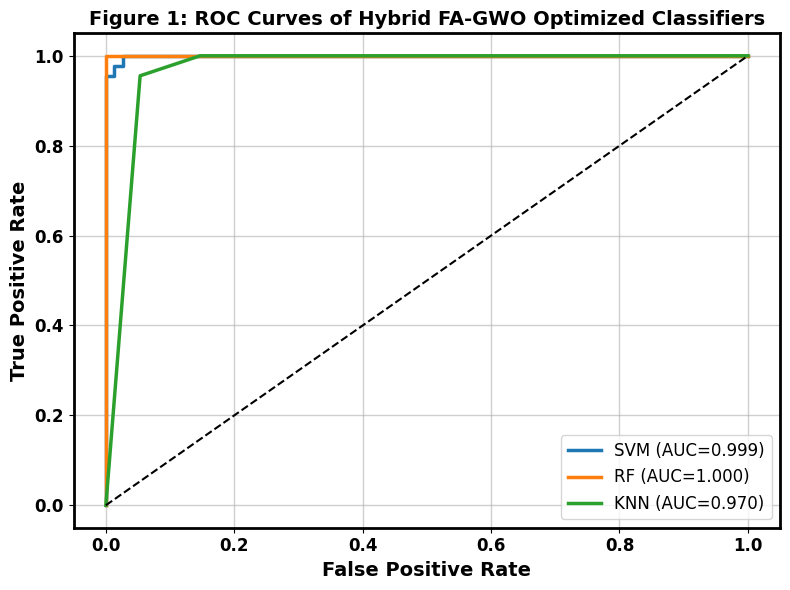

In [ ]:
# ========== Plotting ROC (Figure 1) ==========
plt.figure(figsize=(8, 6))
ax = plt.gca()

for model_key, (fpr, tpr) in roc_data.items():
    if isinstance(model_key, tuple) and model_key[1] == 'Hybrid':
        auc_val = auc(fpr, tpr)
        label = f"{model_key[0]} (AUC={auc_val:.3f})"
        plt.plot(fpr, tpr, label=label, linewidth=2.5)

plt.plot([0, 1], [0, 1], 'k--', lw=1.5)

# Styling
for spine in ax.spines.values():
    spine.set_linewidth(2)

plt.title('Figure 1: ROC Curves of Hybrid FA-GWO Optimized Classifiers', fontsize=14, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.6, linewidth=1)

plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

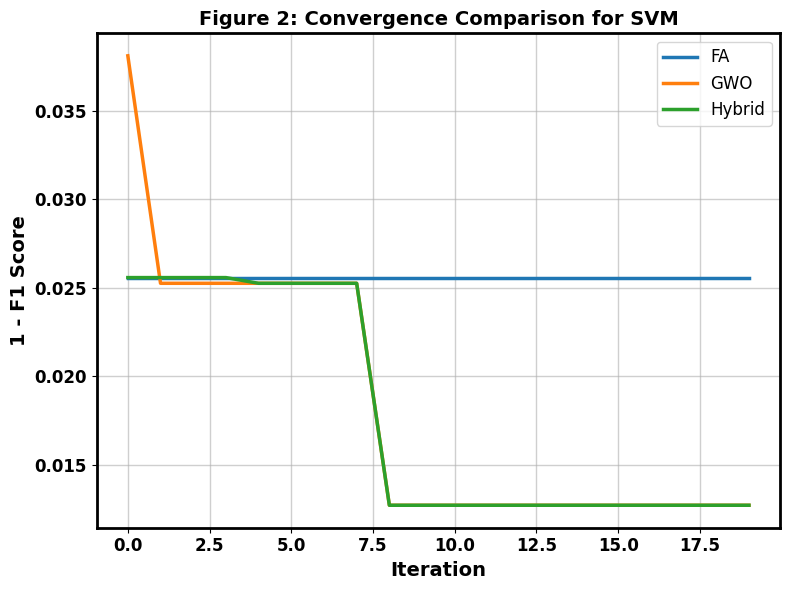

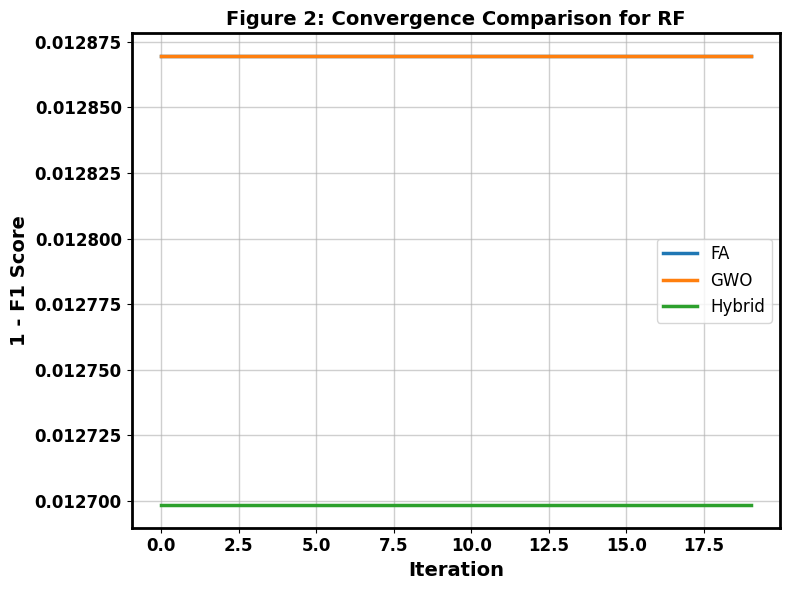

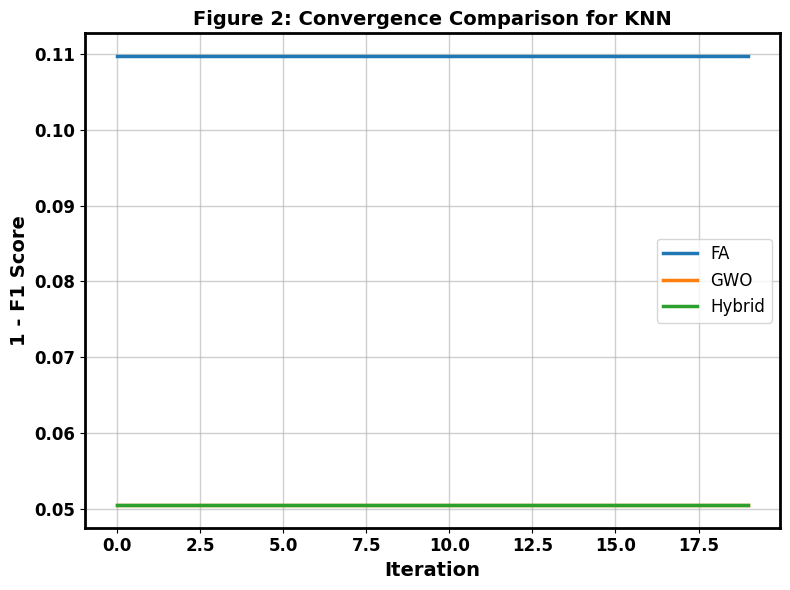

In [ ]:
# ========== Plotting Convergence (Figure 2) ==========
for model in models:
    plt.figure(figsize=(8, 6))
    ax = plt.gca()

    for opt in ['FA', 'GWO', 'Hybrid']:
        plt.plot(convergence[opt][model], label=opt, linewidth=2.5)

    for spine in ax.spines.values():
        spine.set_linewidth(2)

    plt.title(f'Figure 2: Convergence Comparison for {model}', fontsize=14, fontweight='bold')
    plt.xlabel('Iteration', fontsize=14, fontweight='bold')
    plt.ylabel('1 - F1 Score', fontsize=14, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(alpha=0.6, linewidth=1)

    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()